### 1. 目的・背景

ロトカ・ヴォルテラ方程式は、生物学で登場する数理モデルである。これは、自然界における捕食者と被食者の個体数の関係を表現する方程式として知られる。

### 2. 内容

ロトカ・ヴォルテラ方程式の解を数値計算によって求め、捕食者と被食者の個体数が時間と共にどのように変化していくかをみる。また、被食者数と捕食者数をそれぞれ軸にとった解曲線をプロットする。様々な初期設定での解曲線を考えることで、平衡点の存在を視覚的に理解する。さらに、本方程式は理想化されすぎた方程式であるため、改良された類似の方程式がいくつか存在する。そのうちのひとつであるロジスティックモデルを取り入れたものを再び数値計算し、その解を改良前の方程式の解と比較する。

### 3. コードと解説、計算結果、解析

#### 初期設定

In [1]:
#環境を表示させるために下記のコードを実行してください。
import sys
import platform
import psutil
print(sys.version)
print(platform.platform())
print(platform.version())

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19044-SP0
10.0.19044


In [2]:
import numpy as np #必要なモジュールのインポートとmatplotlibの設定
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
plt.rcParams["font.size"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['figure.subplot.left'] = 0.15
plt.rcParams["axes.grid"] = True
plt.rcParams["legend.fontsize"] = 12

In [3]:
def plot_a_fig(xs, ys, num_of_x=1, num_of_y=1, labels=None, xlabel=None, ylabel=None, title=None, method="plot", save=False, figpath=None): #plot用関数(便利かは不明)
    """
    1つだけグラフを書きたいときのショートカット用
    """
    fig, ax = plt.subplots()

    methods = {"plot": ax.plot, "scatter": ax.scatter, "step": ax.step}
    mtd = methods[method]

    if (num_of_x == 1)&(num_of_y==1):
        mtd(xs, ys)
    elif (num_of_x == 1)&(num_of_y!=1):
        for i in range(num_of_y):
            mtd(xs, ys[i])
    elif (num_of_x != 1)&(num_of_y==1):
        for i in range(num_of_x):
            mtd(xs[i], ys)
    else:
        if num_of_x != num_of_y:
            raise ValueError("if you want to plot some xy pairs,\
                 num_of_x and num_of_y must be the same number!")
        for i in range(num_of_y):
            mtd(xs[i], ys[i])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(labels, loc=(1.05, 0))
    ax.set_title(title)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(figpath)

In [4]:
class Solvers: #常微分方程式を数値的に解くクラスSolvers
    
    def __init__(self, f, xv0, t):
        self.f = f
        self.xv0 = xv0
        self.t = t
        self.internal = self.Internal_processes(self.xv0, self.t)
    
    def using_scipy(self, xv0=None, t=None):
        """
        scipy.integrate.odeintによる常微分方程式の解。returnはndarray
        初期値やtを代入しなければ、それらにはインスタンス変数が採用されます。
        """
        xv0 = self.internal.set_initial_values(xv0)
        t = self.internal.set_t(t)
        xv = odeint(self.f, xv0, t)
        return xv

    def rk4(self, xv0=None, t=None):
        """
        4次のルンゲクッタ法による常微分方程式の解。returnはndarray
        初期値やtを代入しなければ、それらにはインスタンス変数が採用されます。
        """
        xv0 = self.internal.set_initial_values(xv0)
        t = self.internal.set_t(t)
        xv = self.internal.set_initial_array(xv0, t)
        for k in range(t.size-1):
            tau = t[k+1] - t[k]
            F1 = self.f(xv[k,:], t[k])
            F2 = self.f(xv[k,:]+tau/2*F1, t[k]+tau/2)
            F3 = self.f(xv[k,:]+tau/2*F2, t[k]+tau/2)  
            F4 = self.f(xv[k,:]+tau*F3, t[k]+tau)
            xv[k+1,:] = xv[k,:] \
                + tau/6 * (F1 +2*F2 +2*F3 +F4)
        return xv

    def euler(self, xv0=None, t=None):
        """
        オイラー法による状微分方程式の解。returnはndarray
        初期値やtを代入しなければ、それらにはインスタンス変数が採用されます。
        """
        xv0 = self.internal.set_initial_values(xv0)
        t = self.internal.set_t(t)
        xv = self.internal.set_initial_array(xv0, t)
        for k in range(t.size-1):
            tau = t[k+1] - t[k]
            xv[k+1,:] = xv[k,:] + self.f(xv[k,:], t)*tau
        return xv

    class Internal_processes:
        def __init__(self, xv0, t):
            self.xv0 = xv0
            self.t = t

        def set_initial_values(self, xv0):
            if xv0==None:
                xv0 = self.xv0
            return xv0

        def set_t(self, t):
            if t==None:
                t = self.t
            return t
        
        def set_initial_array(self, xv0, t):
            m = t.size
            n = xv0.size
            xv = np.zeros([m, n])
            xv[0,:] = xv0
            return xv


In [5]:
class Lotka_Volterra: #本レポートの題材となる微分方程式を定義するクラス
    def __init__(self, a, b, c, d, time_inv, max_day):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.day = np.arange(0, max_day, time_inv)

    #これを変えれば任意の連立線形微分方程式を解ける
    def f(self, xy, t):
        vx = self.a*xy[0] - self.b*xy[0]*xy[1]
        vy = -self.d*xy[1] + self.c*xy[0]*xy[1]
        return np.array([vx, vy])
    
    def conservation(self, x, y):
        return self.c*x + self.b*y - self.d*np.log(x) - self.a*np.log(y)
    
    class F_:
        def __init__(self, g, p, q, d):
            self.g = g
            self.p = p
            self.q = q
            self.d = d

        def f_(self, xy, t=None):
            self.xy = xy
            vx = self.g(xy)*xy[0] - self.p(xy)*xy[1]
            vy = -self.d*xy[1] + self.q(xy)*xy[1]
            return np.array([vx, vy])

    class Logistic:
        def __init__(self, rx, Kx, ry, Ky,):
            self.rx, self.Kx, self.ry, self.Ky = rx, Kx, ry, Ky           

        def logisticx(self,xy):
            return self.rx*(1 - xy[0]/self.Kx)

        def logisticy(self,xy):
            return self.ry*(xy[0] - xy[1]/self.Ky)
    
    class Holling:
        def __init__(self, aa, h):
            self.aa = aa
            self.h = h

        def holling(self, xy):
            return self.aa*xy[0]/(1+self.aa*self.h*xy[0])


In [6]:
def cal_to_plot(a, b, c, d, day_interval, max_day, xy0): #計算からプロットまでを一気に行う関数
    """計算からプロットまでを一気に行う関数"""
    L = Lotka_Volterra(a, b, c, d, day_interval, max_day)

    dif_eq = L.f
    day = L.day
    sol = Solvers(dif_eq, xy0, day)
    results = sol.rk4()
    plot_a_fig(L.day, [results[:,0],results[:,1]], 1, 2, ["被食者数","捕食者数",],\
     "時間 (日)", "個体数 (a.u.)", title="Lotka Volterra方程式の数値解", method="plot")
    ax = plt.gca()
    plt.text(1.07, 0.5, f"a={a}, b={b},\nc={c}, d={d}", bbox=dict(facecolor='white', \
        edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
    plt.text(1.07, 0.98, s=r"$\frac{dx}{dt}=ax-bxy$"+"\n"+r"$\frac{dy}{dt}=cxy-dy$", \
        bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes, va="top")
    plt.text(1.07, 0.28, f"初期値\n$x_0$={round(xy0[0])}, $y_0$={round(xy0[1])}", bbox=dict(facecolor='white', \
        edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
    plt.show()


In [7]:
def differential(t, xy):
    vec = np.zeros_like(xy)
    for i, tmp in enumerate(t[1:-1], 1):
        fp = xy[i+1]
        fm = xy[i-1]
        vec[i] = (fp-fm)/(t[i+1]-t[i-1])
    return vec

def rotation(theta, vector):
    R = np.array([[np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]])
    if vector.size == 1:
        r = np.dot(R, vector)
    else:
        r = np.zeros_like(vector)
        for i in range(len(vector)):
            r[i] = np.dot(R,vector[i])
    return r

def get_norm2D(vector):
    return np.sqrt(vector[:, 0]**2 + vector[:, 1]**2)
def get_norm(vector):
    return np.sqrt(np.sum([vector[:, i]**2 for i in range(len(vector[0]))]))

#### 主要部分

##### Lotka Volterra方程式

解きたい微分方程式  
**ロトカ・ヴォルテラの方程式**<br><br>
$\Large{
    \begin{cases}
        \frac{dx}{dt}=ax-bxy \\
        \frac{dy}{dt}=cxy-dy
    \end{cases}
}\ \ 
\normalsize{(ただし、a, b, c, dは実数定数)}\ \ \ \ (1)$<br><br>
　はじめに述べたように，この方程式は自然界における捕食者と被食者の関係のモデルである．$x$が被食者数，$y$が捕食者数となっており，$x$と$y$が二元連立常微分方程式となっている．
　まずは，係数$a, b, c, d$の意味について考える．第一式は，被食者数の時間変化についての式である．被食者は交配によって自然に増殖する．従って，第一式の第一項は交配による自然増殖率を表している．つまり，係数$a$は交配による1個体の単位時間での増殖率$[/t]$である．一方で，捕食者に殺されることで被食者は減少する．第二項が意味するのは被食者が捕食者に駆逐されることによる被食者数の減少率である．従って，係数$b$は被食者1個体が捕食されることによる単位時間での減少率$[/t*(a.u.)]$である．ここで，生物の数え方の単位はさまざまであるので，a.u.とした．第二式は，捕食者数の時間変化についての式である．捕食者は被食者を食べることで生存し，子孫を残す．第二式の第一項はそのような増殖率を表す項である．従って，係数$c$は被食者1個体を捕食することによる増殖率(転換率)$[/t*(\widetilde{a.u.})]$である．ここで，bの単位と区別するために個体数の単位にチルダを付けた．残った第2項の係数$d$は，捕食者1個体あたりの死亡率[/t]を表す．被食者は，捕食対象がいなければ絶滅してしまう．そのような減少を表すためのこうである．以上をまとめると，
$$
\begin{align*}
&被食者の
\begin{cases}
a: 増殖率\ (交配)\\
b: 1個体が捕食者1個体あたりに捕食される率\\
\end{cases}\\
&捕食者の
\begin{cases}
c: 1捕食あたり増殖率\\
d: 減少率\ (死亡)
\end{cases}
\end{align*}
$$  
となる．  

##### ルンゲクッタ法による数値解

まずはとりあえず4次のルンゲ・クッタ法による数値計算を試みた．その結果を以下の図に示す．

In [8]:
a, b, c, d = 0.04, 0.00003, 0.00002, 0.04 #係数と初期値の設定
day_interval = 1
max_day = 1000
xy0 = np.array([1000, 100])

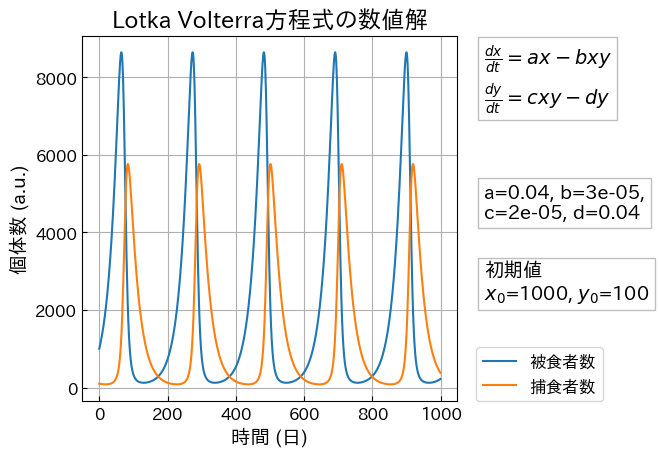

In [9]:
#ルンゲクッタ法による計算
cal_to_plot(a, b, c, d, day_interval, max_day, xy0)

　被食者数と捕食者数は周期的に変動している．変動周期のの順番は以下のようになっている．

1. 被食者数が増加
2. 捕食者数が増加
3. 被食者数が減少
4. 捕食者数が減少<br>

この順番は，必ずしも1から始まるわけではなく，2, 3, 4から始まることもある．しかし，$1→2→3→4→1$の順で起こる．これは，変動が周期的であることから考察できる．また，後で示す解曲線と方向場からも根拠づけられる．

##### 数値計算方法による解の比較

　上で行ったルンゲクッタ法に加えて，`scipy.integrate`の`odeint`モジュール，euler法による計算結果を示す．euler法はTaylor展開の1次までの打ち切りを用いて計算するものである．一般に，euler法はルンゲクッタ法よりも精度が低いことで知られている．

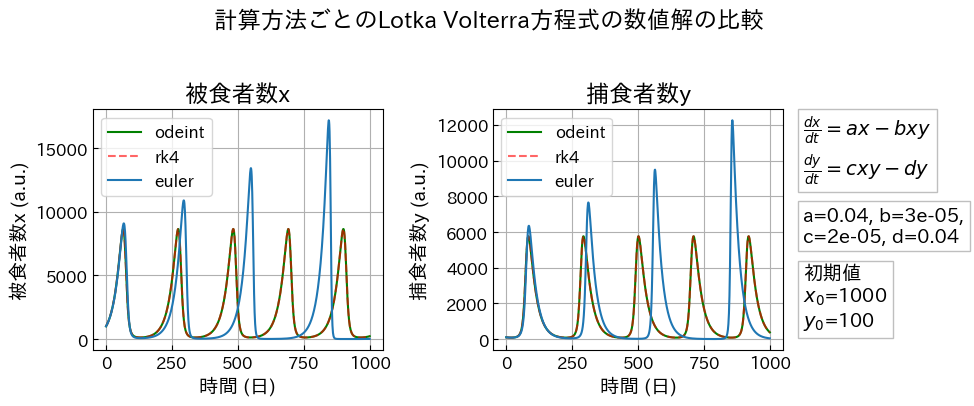

In [10]:
#計算方法ごとのLotka Volterra方程式の数値解の比較
import time
L = Lotka_Volterra(a, b, c, d, day_interval, max_day)
f = L.f
t = L.day
xv0 = np.array([1000, 100])
sol = Solvers(f, xy0, t)
sci_ode = sol.using_scipy()
rk = sol.rk4()
start = time.time()
euler = sol.euler()
caltime_ = time.time() - start
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
xylabel=["被食者数x", "捕食者数y"]
for i, ax in enumerate(axes):
    ax.legend(["odeint", "rk", "euler"])
    ax.plot(t, sci_ode[:, i],color="green")
    ax.plot(t, rk[:, i], "--", color="red", alpha=0.6)
    ax.plot(t, euler[:, i])
    ax.set_xlabel("時間 (日)")
    ax.set_ylabel(f"{xylabel[i]} (a.u.)")
    ax.set_title(f"{xylabel[i]}")
    ax.legend(["odeint", "rk4", "euler"])
fig.suptitle("計算方法ごとのLotka Volterra方程式の数値解の比較", y=1.02)
axx = plt.gca()
axx.text(1.07, 0.45, f"a={a}, b={b},\nc={c}, d={d}", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
axx.text(1.07, 0.98, s=r"$\frac{dx}{dt}=ax-bxy$"+"\n"+r"$\frac{dy}{dt}=cxy-dy$", \
    bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes, va="top")
axx.text(1.07, 0.1, f"初期値\n$x_0$={round(xy0[0])}\n$y_0$={round(xy0[1])}", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
fig.tight_layout()
plt.show()

　一般則に漏れず，euler法による解は他の二つの解に比べて異なる挙動をしている．日数が増えるにつれて，ズレが大きくなっている．後で説明するようにこの方程式には保存量が存在するので，それを用いて解を検証してみる．

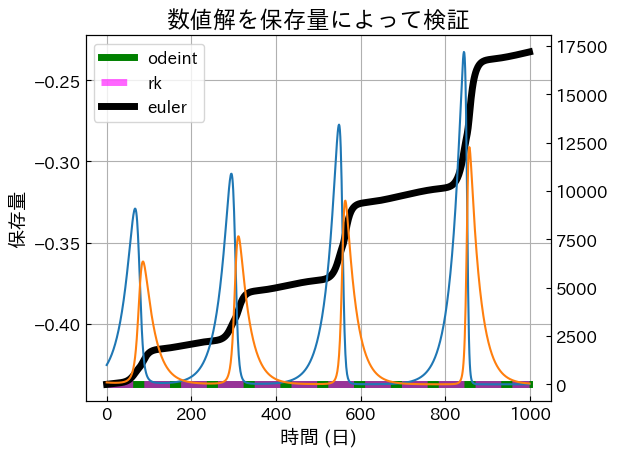

In [11]:
#数値解を保存量によって検証
C_euler = L.conservation(euler[:, 0], euler[:, 1])
C_rk = L.conservation(rk[:, 0], rk[:, 1])
C_odeint = L.conservation(sci_ode[:, 0], sci_ode[:, 1])

fig, ax = plt.subplots()

ax.plot(t, C_odeint, color="green", lw=5)
ax.plot(t, C_rk, "--", color="magenta", alpha=0.6, lw=5)
ax.plot(t, C_euler, color="black", lw=5)
axx = ax.twinx()
axx.plot(t, euler)
axx.grid()
ax.set_xlabel("時間 (日)")
ax.set_ylabel("保存量")
ax.legend(["odeint", "rk", "euler"])
ax.set_title("数値解を保存量によって検証")
fig.tight_layout()
plt.show()

　このように，euler法による数値解は保存量を保存させず，計算誤差が大きいことが分かる．これを改善するには，数値微分における時間の刻み幅を小さくすればよい．時間の刻みを1日から1/50日にした結果が以下の図である．依然として保存量は保存されていないが，1日毎で計算した場合よりも乱れは少なくなっている．

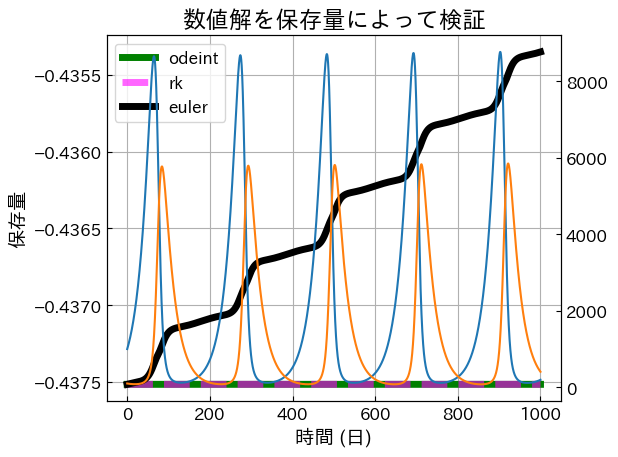

In [12]:
# 1/50日毎で数値微分
import time
L = Lotka_Volterra(a, b, c, d, day_interval/50, max_day)
f = L.f
t = L.day
sol = Solvers(f, xy0, t)
sci_ode = sol.using_scipy()
rk = sol.rk4()
start = time.time()
euler = sol.euler()
caltime = time.time() - start
C_euler = L.conservation(euler[:, 0], euler[:, 1])
C_rk = L.conservation(rk[:, 0], rk[:, 1])
C_odeint = L.conservation(sci_ode[:, 0], sci_ode[:, 1])

fig, ax = plt.subplots()

ax.plot(t, C_odeint, color="green", lw=5)
ax.plot(t, C_rk, "--", color="magenta", alpha=0.6, lw=5)
ax.plot(t, C_euler, color="black", lw=5)
axx = ax.twinx()
axx.plot(t, euler)
axx.grid()
ax.set_xlabel("時間 (日)")
ax.set_ylabel("保存量")
ax.legend(["odeint", "rk", "euler"])
ax.set_title("数値解を保存量によって検証")
fig.tight_layout()
plt.show()

In [13]:
#計算時間の比較
line = "-------------------------------------------"
print(f"計算時間の比較\n\n{line}\n1日ごと: {caltime_} (sec)\n1/50日ごと: {caltime} (sec)\
    \n{line}\n\n1/50日ごとは1日ごとの約{caltime/caltime_:.5g}倍の計算時間がかかる．")

計算時間の比較

-------------------------------------------
1日ごと: 0.009000539779663086 (sec)
1/50日ごと: 0.5199995040893555 (sec)    
-------------------------------------------

1/50日ごとは1日ごとの約57.774倍の計算時間がかかる．


以上より，ルンゲクッタ法と`odeint`による数値解はもっともらしい考えられる．一方でeuler法は保存量の要請を満たしておらず，もっともらしいとは言えない．さらに，時間の刻み幅を細かくして精度向上を図ることも可能だが，計算コストが上がり現実的ではない．

##### 解曲線と方向場，平衡点の存在

様々な初期値で計算を行いそれぞれの場合の解曲線 (相平面図) を描画したものが以下の図である．解曲線は閉曲線となっていることがわかる．解曲線が閉じているということは，$x$と$y$の値が周期的に変化していたことと一致する．方向場が指し示す方向は，左回りである．これは上で説明した周期的変動の増減の順番と一致している．また，$x_0$が小さいほど閉曲線が囲む面積が小さくなっている．このことから，ある初期値を与えれば$x, y$が一切変化しない点，すなわち平衡点の存在が示唆される．

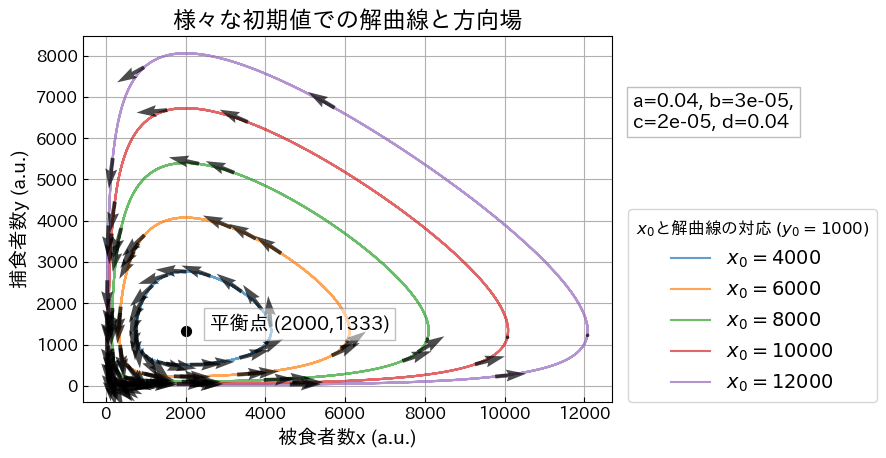

In [14]:
L = Lotka_Volterra(a, b, c, d, day_interval, max_day)
dif_eq = L.f
day = L.day

fig, ax = plt.subplots()
ax.set_title("様々な初期値での解曲線と方向場")
ax.set_xlabel("被食者数x (a.u.)")
ax.set_ylabel("捕食者数y (a.u.)")
fig.tight_layout()
for i, intx in enumerate([d/c*(i+2) for i in range(5)]):
    xy0 = np.array([intx, 1000]) #初期値の変更
    
    sol = Solvers(dif_eq, xy0, day) #上の初期値で計算用classを呼び出し
    results_rk = sol.rk4()
    ax.plot(results_rk[:, 0], results_rk[:, 1], label=f"$x_0={intx:.5g}$", alpha=0.7, zorder=2)

    vector = differential(day, results_rk)
    C = np.sqrt(vector[:, 0]**2 + vector[:, 1]**2)
    n=20
    stop = 401
    ax.quiver(results_rk[1:-1, 0][:stop:n], results_rk[1:-1, 1][:stop:n], 5*vector[:, 0][:stop:n]/(C[:stop:n]+1e-4), 5*vector[:, 1][:stop:n]/(C[:stop:n]+1e-4), zorder=3, alpha=0.7)
ax.scatter(d/c, a/b, 50, color="black")
ax.text(d/c+np.max(results_rk[:, 0])*0.05, a/b+20, f"平衡点 ({round(d/c)},{round(a/b)})", bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5))
ax.text(1.04, 0.75, f"a={a}, b={b},\nc={c}, d={d}", bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
ax.legend(loc=(1.03, 0), title=f"$x_0$と解曲線の対応 $(y_0={xy0[1]:.0f})$", fontsize=14, title_fontsize=12)
plt.show()


実際に平衡点は存在し，以下のように表せる．方程式$(1)$より，  
$\begin{cases}
x(a-by)=0\\ y(cx-d)=0
\end{cases}$  
を解いて  
$\Large{x_0=\frac{d}{c}, y_0=\frac{a}{b}}\ \ \ \ \ \ \normalsize{(2)}$  
となる．この値を初期値に設定すれば，$x$，$y$が恒等的に初期値のままとなることが考えられる．実際に計算を行うと，以下のように確かに$x, y$は一定値となった．

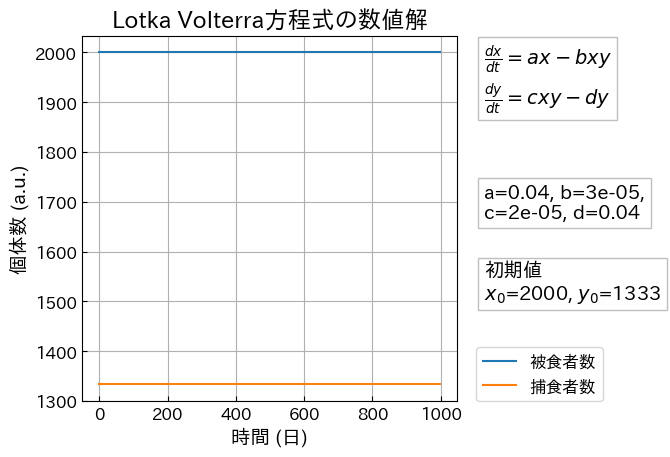

In [15]:
xy0 = np.array([d/c, a/b])
cal_to_plot(a, b, c, d, day_interval, max_day, xy0)

##### 保存量

上の解曲線が閉じた周回軌道を持っていることから推測できるように，Lotka Volterra方程式(1)には保存量が存在する．すなわち，このモデルでは被食者数と捕食者数は保存量$H$を保ちながら変化する．式(1)より，  
$$
\begin{gather*}
    \frac{dx}{dy} &= \frac{ax-bxy}{cxy-dy}\\
    \frac{cx-d}{x}dx &= \frac{a-by}{y}dy
\end{gather*}
$$
両辺を積分して，  
$$H = cx + by - d\log{x} - a\log{y}$$  
保存量を$z$軸にとって三次元で描画すると以下の図のようになった．グラフの底面に示してあるのは，保存量の値のxy平面への射影と等高線である．($a=0.04, b=3\times 10^{-5}, c=2\times 10^{-5}, d=0.04$で綺麗に見えるように設定してある．)

C:\Users\arapi\AppData\Local\Temp\ipykernel_12840\3286648450.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(mappable, shrink=0.7, label="保存量")


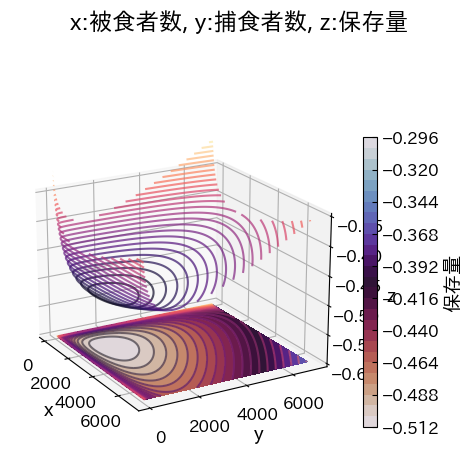

In [16]:
# 保存量の3Dプロット
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

a, b, c, d = 0.04, 0.00003, 0.00002, 0.04
ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d')
x = np.linspace(50, 7000, 2000)
y = np.linspace(50, 7000, 2000)
X, Y = np.meshgrid(x, y)
#Z = c*X + b*Y - d*np.log(X) - a*np.log(Y)
L = Lotka_Volterra(a, b, c, d, day_interval, max_day)
Z = L.conservation(X, Y)

#ax.plot_surface(X, Y, Z, cmap = cm.twilight_r, alpha=0.7)
ax.contour(X, Y, Z, levels=30, cmap=cm.magma, alpha=0.7)
mappable = ax.contourf(X, Y, Z, levels=30, zdir='z', offset=-0.6, cmap=cm.twilight_r, )
ax.contour(X, Y, Z, levels=30, zdir='z', offset=-0.6, cmap=cm.magma, alpha=0.5)
fig = plt.gcf()
fig.colorbar(mappable, shrink=0.7, label="保存量")
ax.set_zlim(-0.6, -0.35)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(elev=20, azim=-30,)
fig.suptitle("x:被食者数, y:捕食者数, z:保存量", y=1)
fig.tight_layout()
plt.show()



<br>

##### 方程式の改良

方程式$(1)$は，いくつか単純化しすぎた部分がある．例えば，被食者が生活するための資源は無限にあると仮定しているために，捕食者がいない場合に被食者は指数関数的に増大してしまう点である．同様に，被食者数に比例して捕食者が増加する点も改善の余地がある．

さらに，捕食者が捕食するための時間を考慮した方程式も存在する．(文献3)

方程式(1)をこのような方程式に改良する。  
$\begin{cases}
\frac{dx}{dt} = g(x)x - p(x, y)y\\
\frac{dy}{dt} = q(x, y)x - dy\\
\end{cases}$

まず、$g$, $q$をロジスティック方程式と似たような形に変形する。 $p$は(1)のままとする。   
$g(x) = r_x(1-\frac{x}{K_x})\\q(x, y) = r_y(x-\frac{x}{K_y})$

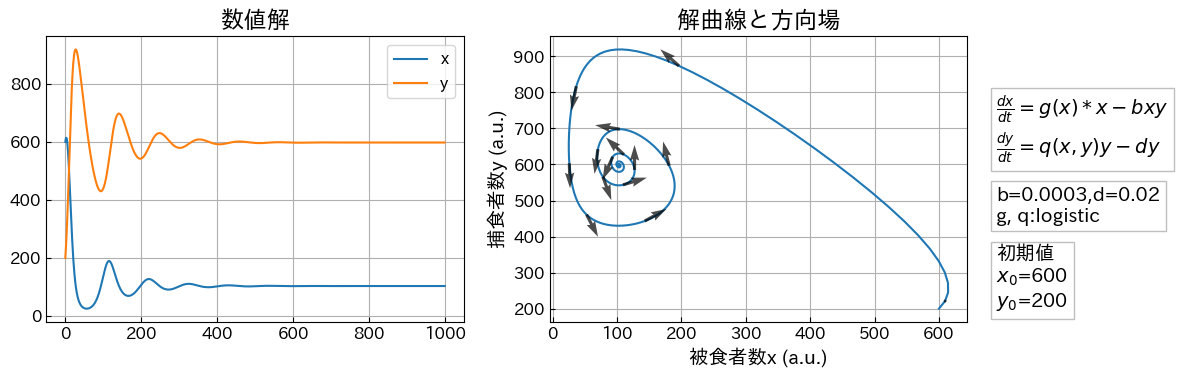

In [17]:
a, b, c, d = 0.2, 0.0003, 0.0002, 0.02
rx, Kx, ry, Ky = 0.2, 1000, 0.0002, 200
day_interval = 1
max_day = 1000
L = Lotka_Volterra(a, b, c, d, day_interval, max_day)
logistic = L.Logistic(rx, Kx, ry, Ky)
g = logistic.logisticx
q = logistic.logisticy
p = lambda xy: L.b*xy[0]
dd = L.d

F = L.F_(g, p, q, dd)
f = F.f_
t = L.day
xy0 = np.array([600, 200])
sol = Solvers(f, xy0, t)
rk = sol.rk4()
vec = differential(t, rk)
C = get_norm2D(vec)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
titles = ["数値解", "解曲線と方向場"]
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
axes[1].set_xlabel("時間 (日)")
axes[1].set_ylabel("個体数 (a.u.)")
axes[1].set_xlabel("被食者数x (a.u.)")
axes[1].set_ylabel("捕食者数y (a.u.)")

axes[0].plot(t, rk)
axes[0].legend(["x", "y"])
axes[1].plot(rk[:,0],rk[:,1])
#axes[1].quiver(rk[:,0],rk[:,1],vec[:,0]/C, vec[:,1]/C )
ax = axes[1]
axes[1].text(1.07, 0.35, f"b={b},d={d}\ng, q:logistic", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
axes[1].text(1.07, 0.8, s=r"$\frac{dx}{dt}=g(x)*x-bxy$"+"\n"+r"$\frac{dy}{dt}=q(x,y)y-dy$", \
    bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes, va="top")
axes[1].text(1.07, 0.05, f"初期値\n$x_0$={round(xy0[0])}\n$y_0$={round(xy0[1])}", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
fig.tight_layout()
vector = differential(t, rk)
C = np.sqrt(vector[:, 0]**2 + vector[:, 1]**2)
n=20
stop = 261
ax.quiver(rk[1:-1, 0][:stop:n], rk[1:-1, 1][:stop:n], 5*vector[:, 0][:stop:n]/(C[:stop:n]+1e-4), 5*vector[:, 1][:stop:n]/(C[:stop:n]+1e-4), zorder=3, alpha=0.7)

つぎに、$g$, $p$,$q$をロジスティックとholling関数といわれる式を用いてみる。(文献3)   
$g(x) = r_x(1-\frac{x}{K_x})\\ p(x) = q(x) = \frac{ax}{1-ahx}$

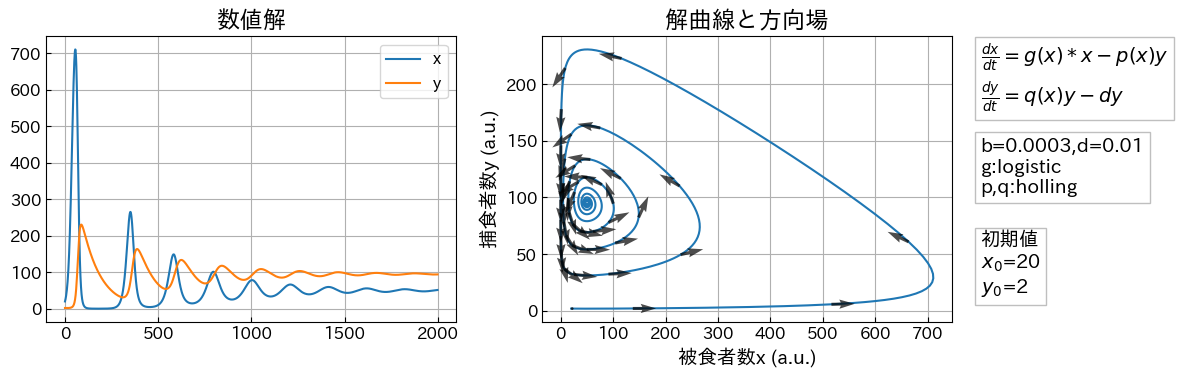

In [18]:
#a, b, c, d = 0.2, 0.0003, 0.0002, 0.01
#rx, Kx, ry, Ky = 0.1, 1000, 0.007, 600
#aa, h, l = 0.0002, 0.2, 5
#xy0 = np.array([20, 2])

a, b, c, d = 0.2, 0.0003, 0.0002, 0.01
rx, Kx, ry, Ky = 0.1, 1000, 0.007, 600
aa, h, l = 0.0002, 0.2, 5
day_interval = 1
max_day = 2000
L = Lotka_Volterra(a, b, c, d, day_interval, max_day)
logistic = L.Logistic(rx, Kx, ry, Ky)
holling = L.Holling(aa, h)
g = logistic.logisticx
q = holling.holling
p = lambda xy: l*q(xy)
dd = L.d

F = L.F_(g, p, q, dd)
f = F.f_
t = L.day
xy0 = np.array([20, 2])
sol = Solvers(f, xy0, t)
rk = sol.rk4()
vec = differential(t, rk)
C = get_norm2D(vec)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
titles = ["数値解", "解曲線と方向場"]
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
axes[1].set_xlabel("時間 (日)")
axes[1].set_ylabel("個体数 (a.u.)")
axes[1].set_xlabel("被食者数x (a.u.)")
axes[1].set_ylabel("捕食者数y (a.u.)")
axes[0].plot(t, rk)
axes[0].legend(["x", "y"])
axes[1].plot(rk[:,0],rk[:,1])
#axes[1].quiver(rk[:,0],rk[:,1],vec[:,0]/C, vec[:,1]/C )
ax = axes[1]
axes[1].text(1.07, 0.45, f"b={b},d={d}\ng:logistic\np,q:holling", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
axes[1].text(1.07, 0.98, s=r"$\frac{dx}{dt}=g(x)*x-p(x)y$"+"\n"+r"$\frac{dy}{dt}=q(x)y-dy$", \
    bbox=dict(facecolor='white', edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes, va="top")
axes[1].text(1.07, 0.1, f"初期値\n$x_0$={round(xy0[0])}\n$y_0$={round(xy0[1])}", bbox=dict(facecolor='white', \
    edgecolor="grey", alpha=0.5), fontsize=14, transform=ax.transAxes)
fig.tight_layout()
vector = differential(t, rk)
C = np.sqrt(vector[:, 0]**2 + vector[:, 1]**2)
n=20
stop = 881
axes[1].quiver(rk[1:-1, 0][:stop:n], rk[1:-1, 1][:stop:n], 5*vector[:, 0][:stop:n]/(C[:stop:n]+1e-4), 5*vector[:, 1][:stop:n]/(C[:stop:n]+1e-4), zorder=3, alpha=0.7)



<br>

### 4. 参考文献リスト

1. 小高知宏, Pythonによる数値計算とシミュレーション, 2018
2. 堀畑和弘, 長谷川浩司, 常微分方程式の新しい教科書, 2016
3. 今隆助, 竹内康博, 状微分方程式とロトカ・ヴォルテラ方程式, 2018